In [1]:
# This will install scikit learn extra if needed
!pip install scikit-learn-extra

import numpy as np 
# glob is used for manipulating files
import glob
import scipy
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from  sklearn_extra.cluster import KMedoids
import matplotlib.patches as mpatches

     ---------------------------------------- 0.0/819.0 kB ? eta -:--:--
     --- ----------------------------------- 71.7/819.0 kB 1.3 MB/s eta 0:00:01
     --- ----------------------------------- 71.7/819.0 kB 1.3 MB/s eta 0:00:01
     -------- ----------------------------- 174.1/819.0 kB 1.3 MB/s eta 0:00:01
     ---------- --------------------------- 225.3/819.0 kB 1.4 MB/s eta 0:00:01
     ----------- -------------------------- 245.8/819.0 kB 1.2 MB/s eta 0:00:01
     --------------- ---------------------- 327.7/819.0 kB 1.4 MB/s eta 0:00:01
     ------------------ ------------------- 389.1/819.0 kB 1.3 MB/s eta 0:00:01
     ------------------- ------------------ 419.8/819.0 kB 1.3 MB/s eta 0:00:01
     ---------------------- --------------- 491.5/819.0 kB 1.3 MB/s eta 0:00:01
     ------------------------ ------------- 532.5/819.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------- --------- 604.2/819.0 kB 1.3 MB/s eta 0:00:01
     ------------------------------ ------- 655

  error: subprocess-exited-with-error
  
  × Building wheel for scikit-learn-extra (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [74 lines of output]
      C:\Users\Mattia\AppData\Local\Temp\pip-build-env-2eqzqcrf\overlay\Lib\site-packages\setuptools\dist.py:599: SetuptoolsDeprecationWarning: Invalid dash-separated key 'description-file' in 'metadata' (setup.cfg), please use the underscore name 'description_file' instead.
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
              (Affected: scikit-learn-extra).
      
              By 2026-Mar-03, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguid

ModuleNotFoundError: No module named 'sklearn_extra'

In [2]:

files = ["./walking.csv", "./running.csv"]

# Finding the number of classes (the number of classes is the number of files since we assume each file is for a different class)
num_classes = len(files)
num_channels = 2

# Loading all the files into a list
data_per_class        = []
num_samples_per_class = []
num_windows_per_class = []

# Defining window length and step size
window_length     = 50
window_step_size  = 25

# Loading the files and finding the number of samples and windows for each class
for file in files:
    data = np.loadtxt(file, delimiter=",")
    
    total_acc = data[:, 0]**2 + data[:, 1]**2 + data[:, 2]**2
    total_gyro = data[:, 3]**2 + data[:, 4]**2 + data[:, 5]**2
    
    total_acc = np.sqrt(total_acc)[:, None]
    total_gyro = np.sqrt(total_gyro)[:, None]

    data = np.concatenate([total_acc, total_gyro], axis = 1)
    
    data_per_class.append(data) 
    num_samples = data.shape[0]
    num_samples_per_class.append(num_samples)
    num_windows = (num_samples - window_length) // window_step_size + 1
    num_windows_per_class.append(num_windows)
    
sliding_windows_per_class = []

# Creating the sliding windows
for class_id in range(0, num_classes):
    num_windows = num_windows_per_class[class_id]
    sliding_windows = np.zeros((num_windows, window_length, num_channels))
    for i in range(0, num_windows):
        sliding_windows[i, ...] = data_per_class[class_id][i*window_step_size: i*window_step_size + window_length]
    sliding_windows_per_class.append(sliding_windows)
    
# Extracting features
# Let's use the mean of the total acc and total angular speed
features_per_class = [] 

for class_id in range(0, num_classes):
    num_windows = num_windows_per_class[class_id]
    sliding_windows = sliding_windows_per_class[class_id]
    features = np.mean(sliding_windows, axis = 1)
    features_per_class.append(features)
    
# We now split the data into train and test sets
train_portion = 0.80

num_windows_all_classes = np.sum(num_windows_per_class)

# Creating lists that will store the train, val and test portions of all classes
X_train = []
Y_train = []
X_test = []
Y_test = []

for class_id in range(0, num_classes):
    num_windows = num_windows_per_class[class_id]
    num_windows_train = int(num_windows*train_portion)
    num_windows_test = num_windows - num_windows_train
    
    features = features_per_class[class_id]
    x_train, x_test = np.split(features, [num_windows_train], axis = 0)
    y_train, y_test = np.ones(num_windows_train)*class_id, np.ones(num_windows_test)*class_id
    
    X_train.append(x_train)
    Y_train.append(y_train)    
    X_test.append(x_test)
    Y_test.append(y_test)
    
# Concatenating into a single array
X_train = np.concatenate(X_train, axis = 0)
Y_train = np.concatenate(Y_train, axis = 0).astype(int)

X_test = np.concatenate(X_test, axis = 0)
Y_test = np.concatenate(Y_test, axis = 0).astype(int)

# Data normalization. We obtain the mean and std on the training set
data_mean = np.mean(X_train, axis = 0)
data_std  = np.std(X_train, axis = 0)

# We normalize the sets using the mean and std found above
X_train = (X_train - data_mean)/data_std
X_test  = (X_test - data_mean)/data_std


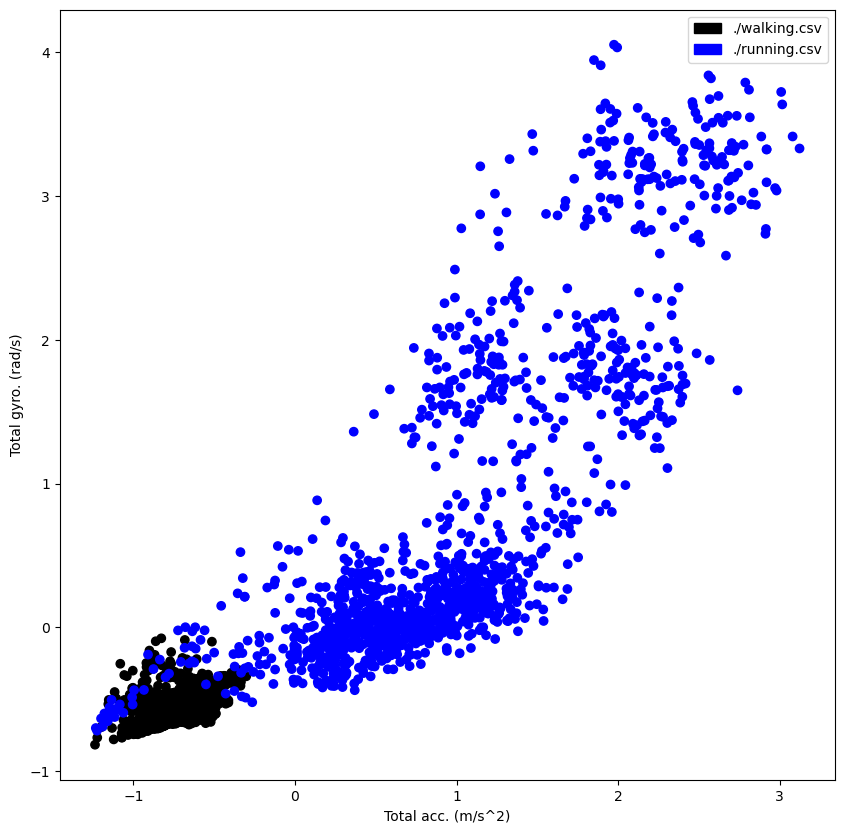

In [3]:
# Now let's visualize the features, with colors according to their class
plt.figure(figsize=(10,10))

base_colors = ['black', 'blue']
point_colors = [base_colors[i] for i in Y_train]

# Plotting the data
plt.scatter(X_train[:, 0], X_train[:, 1],  c = point_colors)

# Setting the x and y labels of the plot
plt.xlabel("Total acc. (m/s^2)")
plt.ylabel("Total gyro. (rad/s)")

# Setting the legend in the plot
patch1 = mpatches.Patch(color=base_colors[0], label=files[0])
patch2 = mpatches.Patch(color=base_colors[1], label=files[1])

plt.legend(handles=[patch1, patch2])


In [4]:
# Creating the k-means clustering algorithm and training it
kmeans = KMeans(n_clusters=num_classes, max_iter = 500, n_init = 'auto')
kmeans.fit(X_train)

kmedoids =  KMedoids(n_clusters=num_classes, max_iter = 500)
kmedoids.fit(X_train)

KMedoids(max_iter=500, n_clusters=2)

In [5]:
# Class 0 corresponds to walking
# Class 1 corresponds to running

# Cluster 0 corresponds to the cluster at the center (x, y) = (centers[0, 0], centers[0, 1])
# Cluster 1 corresponds to the cluster at the center (x, y) = (centers[1, 0], centers[1, 1])

kmeans_centers = kmeans.cluster_centers_
kmedoids_centers = kmedoids.cluster_centers_

# Notice that walking has lower mean total acc and lower mean total gyro
if kmeans_centers[0, 0] <= kmeans_centers[1, 0]:
    prediction_kmeans = kmeans.predict(X_test)
else:
    # if this is true, then the cluster 0 is jumping (the opposite of the order of classes because class 0 is walking)
    prediction_kmeans = 1-kmeans.predict(X_test)


if kmedoids_centers[0, 0] <= kmedoids_centers[1, 0]:
    prediction_kmedoids = kmedoids.predict(X_test)
else:
    prediction_kmedoids = 1-kmedoids.predict(X_test)


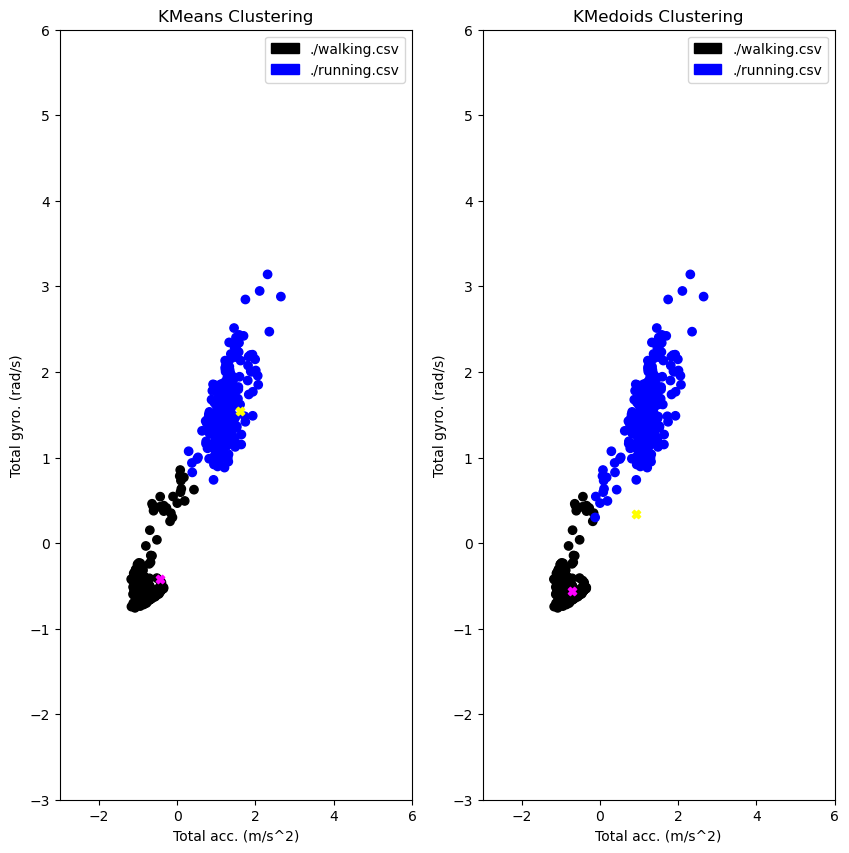

In [6]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # 1 row, 2 columns

base_colors = ['black', 'blue']
point_colors_kmeans = [base_colors[i] for i in prediction_kmeans] ## i in kmeans.predict(X_train)]
point_colors_kmedoids = [base_colors[i] for i in prediction_kmedoids]

# Setting the legend in the plot
patch1 = mpatches.Patch(color=base_colors[0], label=files[0])
patch2 = mpatches.Patch(color=base_colors[1], label=files[1])

# Scatter plot 1
axs[0].scatter(X_test[:, 0], X_test[:, 1], color=point_colors_kmeans)
axs[0].set_title('KMeans Clustering')
axs[0].set_xlabel('Total acc. (m/s^2)')
axs[0].set_ylabel('Total gyro. (rad/s)')
axs[0].legend(handles=[patch1, patch2])
axs[0].set_xlim([-3, 6])
axs[0].set_ylim([-3, 6])

# Scatter plot 2
axs[1].scatter(X_test[:, 0], X_test[:, 1], color=point_colors_kmedoids)
axs[1].set_title('KMedoids Clustering')
axs[1].set_xlabel('Total acc. (m/s^2)')
axs[1].set_ylabel('Total gyro. (rad/s)')
axs[1].legend(handles=[patch1, patch2])
axs[1].set_xlim([-3, 6])
axs[1].set_ylim([-3, 6])


axs[0].scatter(kmeans_centers[0, 0], kmeans_centers[0, 1], marker='X', c = 'yellow')
axs[0].scatter(kmeans_centers[1, 0], kmeans_centers[1, 1], marker='X', c = 'magenta')

axs[1].scatter(kmedoids_centers[0, 0], kmedoids_centers[0, 1], marker='X', c = 'yellow')
axs[1].scatter(kmedoids_centers[1, 0], kmedoids_centers[1, 1], marker='X', c = 'magenta')


Let's calculate the mean silhouette score. The silhouette score is a value in the range from -1 to 1 and is calculated for all samples in the data.

A silhouette score close to +1 indicates that the data point is well matched to its own cluster and poorly matched to neighboring clusters. This is a sign of good clustering, where the clusters are distinct and well-separated.

A silhouette score around 0 suggests overlapping clusters, where the distance between clusters is not significant compared to the spread of data points within clusters. It indicates that the data points may be on the border between two clusters.

A silhouette score close to -1 indicates that the data point is likely assigned to the wrong cluster. This may occur when clusters overlap significantly, and the algorithm struggles to distinguish between them.



# s = (b - a) / max(a, b)

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. 

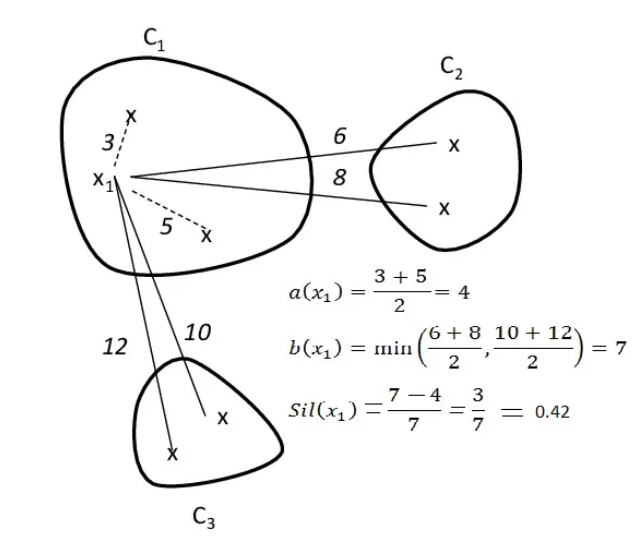

In [7]:
from sklearn.metrics import silhouette_score

# Calculating the silhouette score
s_score_kmeans = silhouette_score(X_test, prediction_kmeans)
s_score_kmedoids = silhouette_score(X_test, prediction_kmedoids)
print(f'Calculated mean silhouette score for Kmeans: {s_score_kmeans}')
print(f'Calculated mean silhouette score for Kmedoids: {s_score_kmedoids}')

Calculated mean silhouette score for Kmeans: 0.8473281552742643
Calculated mean silhouette score for Kmedoids: 0.8491585264176718


In [8]:
# Since we also have the labels, we can calculate the accuracy by using the Kmeans clustering method as a classification method.
# Note: this is not the case in real life, because if we had the labels, we could have simply trained a classifier.

from sklearn.metrics import accuracy_score

accuracy_kmeans = accuracy_score(Y_test, prediction_kmeans)
print(f'Calculated accuracy KMeans: {accuracy_kmeans}')
accuracy_kmedoids = accuracy_score(Y_test, prediction_kmedoids)
print(f'Calculated accuracy KMedoids: {accuracy_kmedoids}')

Calculated accuracy KMeans: 0.9465558194774347
Calculated accuracy KMedoids: 0.9596199524940617


To better illustrate, we can plot the data points again. This time we will color in green the points that are assigned to the correct cluster and in read otherwise.

(-3.0, 6.0)

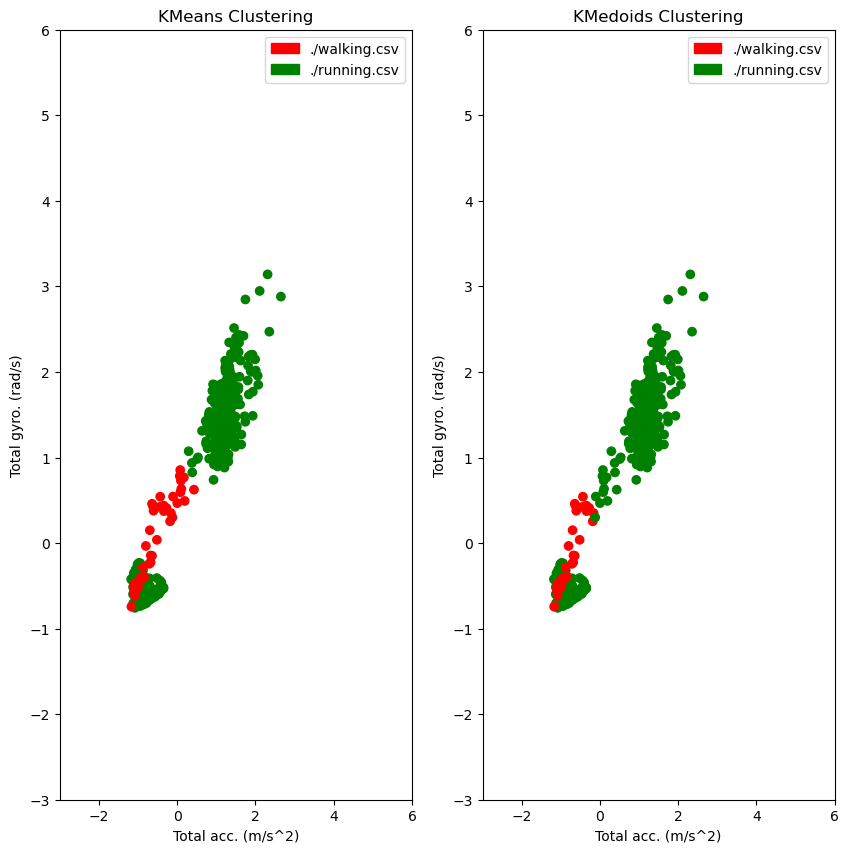

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # 1 row, 2 columns

base_colors = ['red', 'green']
# if prediction = true label, matches_kmeans=1, else 0
matches_kmeans = prediction_kmeans == Y_test
matches_kmeans = matches_kmeans.astype(int)
point_colors_kmeans = [base_colors[i] for i in matches_kmeans]

matches_kmedoids = prediction_kmedoids == Y_test
matches_kmedoids = matches_kmedoids.astype(int)
point_colors_kmedoids = [base_colors[i] for i in matches_kmedoids]

# Setting the legend in the plot
patch1 = mpatches.Patch(color=base_colors[0], label=files[0])
patch2 = mpatches.Patch(color=base_colors[1], label=files[1])

# Scatter plot 1
axs[0].scatter(X_test[:, 0], X_test[:, 1], color=point_colors_kmeans)
axs[0].set_title('KMeans Clustering')
axs[0].set_xlabel('Total acc. (m/s^2)')
axs[0].set_ylabel('Total gyro. (rad/s)')
axs[0].legend(handles=[patch1, patch2])
axs[0].set_xlim([-3, 6])
axs[0].set_ylim([-3, 6])

# Scatter plot 2
axs[1].scatter(X_test[:, 0], X_test[:, 1], color=point_colors_kmedoids)
axs[1].set_title('KMedoids Clustering')
axs[1].set_xlabel('Total acc. (m/s^2)')
axs[1].set_ylabel('Total gyro. (rad/s)')
axs[1].legend(handles=[patch1, patch2])
axs[1].set_xlim([-3, 6])
axs[1].set_ylim([-3, 6])